# Multi-class Chest X-ray Classification: COVID-19 vs. Normal vs. Bac Pneumonia vs. Vir Pneumonia

## Data

Chest X-ray data is available here: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* Data structures:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* In this file, we will do chest X-ray multi-class classification, we will focus on the *all* folder



In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
import warnings
from sklearn.manifold import TSNE
import matplotlib.image as mpimg
import itertools
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models,layers
from tensorflow.keras.applications import VGG16,ResNet50, VGG19, InceptionV3,DenseNet201,NASNetMobile,ResNet152,Xception
warnings.filterwarnings('ignore')

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.10.0'

### Load Image Data

In [5]:
SOURCE_PATH = '../data'
DATASET_PATH  = os.path.join(SOURCE_PATH, 'all/train')
TEST_DIR = os.path.join(SOURCE_PATH, 'all/test')
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = 4
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 50
LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 

### Data Augmentation

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=15,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.1,
                                   height_shift_range=0.1,shear_range=0.1,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = False,vertical_flip = False,
                                   validation_split = 0.1,fill_mode='constant')

### Generate Training and Validation Batches

In [7]:
train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

Found 243 images belonging to 4 classes.
Found 27 images belonging to 4 classes.


## Transfer Learning

We took advantage of pre-trained model such as VGG-16 and DenseNet201

We froze all layers in pre-trained model and added 2 fully-connected layers at the end of the model

In [8]:
def get_model(model_name: str):
    if model_name == "VGG-16":
        pre_trained_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == "VGG-19":
        pre_trained_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == "Xception":
        pre_trained_model = Xception(weights='imagenet',include_top = False,input_shape = (224,224,3))
    elif model_name == "Inception":
        pre_trained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == "DenseNet201":
        pre_trained_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == "MobileNet":
        pre_trained_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == "ResNet152":
        pre_trained_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        raise ValueError(f"Invalid model name: {model_name}. Choose from ['VGG-16', 'VGG-19', 'Xception', 'Inception', 'DenseNet201', 'MobileNet', 'ResNet152']")
    return pre_trained_model


In [9]:
# acquire pre-trained model
pre_train_model = get_model("DenseNet201")

# define our own sequential model
model = models.Sequential()
model.add(pre_train_model)
model.add(layers.AveragePooling2D(pool_size=(4,4)))
model.add(layers.Flatten())

# add two fully-connected NN
model.add(layers.Dense(256, activation='relu',name='dense_feature'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(4, activation='softmax', name='clf_layer'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['acc'])

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-07-12 17:02:02.706935: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-12 17:02:02.707078: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Train Model

In [10]:
print(f"Number of train batches: {len(train_batches)}")
print(f"Number of valid batches: {len(valid_batches)}")

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

model.fit(train_batches,
                steps_per_epoch =STEP_SIZE_TRAIN,
                validation_data = valid_batches,
                validation_steps = STEP_SIZE_VALID,
                epochs= NUM_EPOCHS, verbose = 1)

Number of train batches: 25
Number of valid batches: 3
Epoch 1/50


2023-07-12 17:02:32.144247: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-12 17:02:40.432208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 1.3714 - acc: 0.3519

2023-07-12 17:03:34.695096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 74s 2s/step - loss: 1.3714 - acc: 0.3519 - val_loss: 1.6445 - val_acc: 0.2500
Epoch 2/50
24/24 [==============================] - 8s 338ms/step - loss: 0.8771 - acc: 0.6223 - val_loss: 1.3663 - val_acc: 0.3500
Epoch 3/50
24/24 [==============================] - 8s 324ms/step - loss: 0.6879 - acc: 0.7210 - val_loss: 2.0285 - val_acc: 0.2000
Epoch 4/50
24/24 [==============================] - 7s 304ms/step - loss: 0.5408 - acc: 0.7897 - val_loss: 1.5615 - val_acc: 0.3500
Epoch 5/50
24/24 [==============================] - 7s 296ms/step - loss: 0.4500 - acc: 0.8197 - val_loss: 1.6014 - val_acc: 0.4000
Epoch 6/50
24/24 [==============================] - 7s 270ms/step - loss: 0.3422 - acc: 0.8627 - val_loss: 1.5440 - val_acc: 0.3500
Epoch 7/50
24/24 [==============================] - 7s 298ms/step - loss: 0.3635 - acc: 0.8584 - val_loss: 1.5203 - val_acc: 0.3000
Epoch 8/50
24/24 [==============================] - 7s 268ms/step - loss: 0.2925 - acc: 0

### Plot Accuracy and Loss During Training

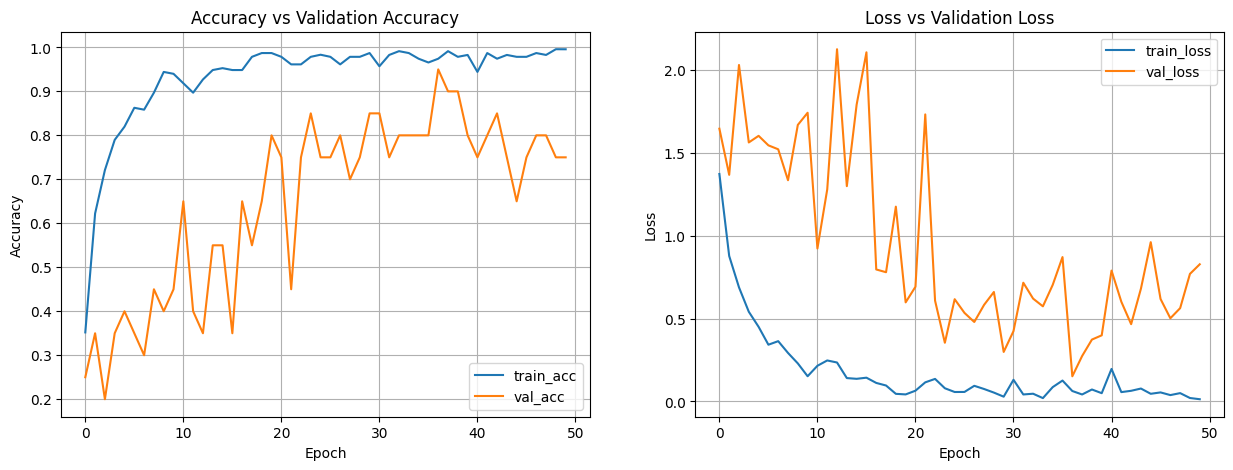

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(model.history.history['acc'], label='train_acc')
plt.plot(model.history.history['val_acc'], label = 'val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy vs Validation Accuracy")
plt.grid(True)
plt.legend(loc='lower right')
plt.subplot(122)
plt.plot(model.history.history['loss'], label='train_loss')
plt.plot(model.history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss vs Validation Loss")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

#### Testing Model

In [14]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
36/36 [==============================] - 19s 134ms/step - loss: 0.6494 - acc: 0.7500
Test loss: 0.6494482159614563
Test accuracy: 0.75


In [15]:
predictions = model.predict(x=eval_generator,steps=len(eval_generator), verbose=0)

2023-07-12 17:10:54.700643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


### Plot the Confusion Matrix

In [16]:
cm = confusion_matrix(y_true=eval_generator.classes,y_pred=np.argmax(predictions, axis=-1))

In [17]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_true=eval_generator.classes,y_pred=np.argmax(predictions, axis=-1))
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.78      0.88         9
           2       0.55      0.67      0.60         9
           3       0.56      0.56      0.56         9

    accuracy                           0.75        36
   macro avg       0.78      0.75      0.76        36
weighted avg       0.78      0.75      0.76        36



In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[9 0 0 0]
 [0 7 1 1]
 [0 0 6 3]
 [0 0 4 5]]


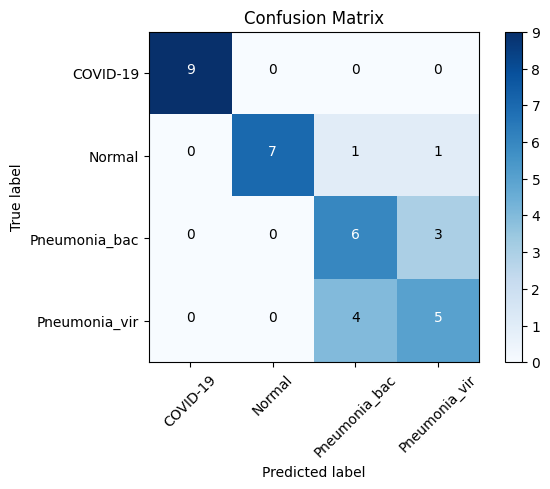

In [19]:
cm_plot_labels = ['COVID-19','Normal','Pneumonia_bac','Pneumonia_vir']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## TSNE Plot

Examine the image embedding using T-SNE

Found 270 images belonging to 4 classes.


270


2023-07-12 17:11:40.599302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


The feature is a  256 dimensional vector


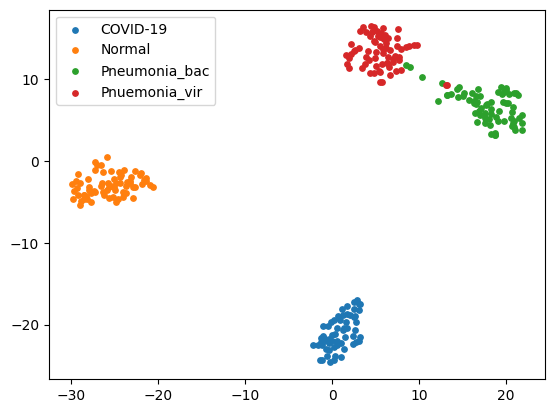

In [20]:
intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense_feature').output)
tsne_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")


print(len(tsne_data_generator))
feature = intermediate_layer_model.predict_generator(tsne_data_generator,len(tsne_data_generator))
print("The feature is a ", len(feature[0]), "dimensional vector")


labels = np.array([int(tsne_data_generator[i][1][0]) for i in range(len(tsne_data_generator))])

tsne = TSNE(n_components=2, random_state=42)
twoD_rep = tsne.fit_transform(feature)

legends = ['COVID-19','Normal','Pneumonia_bac', 'Pnuemonia_vir']

for i in range(NUM_CLASSES):
    plt.scatter(twoD_rep[labels == i, 0], twoD_rep[labels == i, 1], 
                marker='o',s=15,label=legends[i])

plt.legend()
plt.show()

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->